# Vision Networks and Fast Training: Transfer Learning

In this notebook, we will take a closer look at some famous vision architectures.
Since most of these architectures are very large, it requires high-end hardware to train from scratch.
To leverage the limited availability of hardware, also *Transfer Learning* can be used. 
By using stored weights of a large network a new network can be trained cheaply on new datasets.

In [2]:
import torch
import torchvision
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm.notebook import trange

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)

print('Python version: 3.9.12')
print('Pytorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

Python version: 3.9.12
Pytorch version: 1.13.0
torchvision version: 0.14.0


## LeNet-5 and its Offspring

![LeNet-5 architecture](https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png)

The LeNet-5 architecture (depicted above) is one of the first convolutional networks.
Since convolutions are extremely well suited for many computer vision tasks,
a wide variety of network architectures using convolutional layers has become available.
Although the differences in performance are sometimes large,
the architectures can generally be considered variations on the same theme.

###### Alexnet

![alex-net architecture](https://cdn-images-1.medium.com/max/1000/1*wzflNwJw9QkjWWvTosXhNw.png)

In 2012 Alex Krizhevsky et al. won the [Imagenet Large Scale Visual Recognition Challenge](http://www.image-net.org/challenges/LSVRC/) (ILSVRC).
The network they used, which is known as *Alex-net*, is depicted below and follows the same basic principles as LeNet-5.
Alex-net has quite a bit more parameters than LeNet-5, therefore it requires a large amount of computational resources to train.

To speed up training time, Alex-net was trained on GPU.
Since GPUs have access to little memory compared to CPUs (especially back in the days),
alex-net did not fit on a single GPU and required 2 GPUs to train the model,
hence the distinction between two paths in the illustration of the network.

On modern GPUs, it is no longer a problem to fit alex-net on a single GPU.
Due to the fact that deep learning frameworks mostly support hardware acceleration, 
it has even become extremely easy and almost common to train (large) networks on GPUs.
A more detailed description on how to achieve this in pytorch, is given below.

Another important add-on, is the use of the dropout regularisation technique in the fully connected layers.
From DL & NN 1 you should remember that dropout behaves differently during testing and training.
When using Dropout or other modules with different behaviour, e.g. BatchNorm, in pytorch, 
it is important to make sure that your network operates in the right mode.
To do this, the `nn.Module` class provides the `train` and `eval` methods
and invokes it on all submodules to assure that the desired behaviour is triggered.

### Pytorch GPU acceleration

In pytorch, training a model on GPU is relatively easy.
To copy a tensor `x` from main memory (or wherever it may be) to GPU memory,
all we need to do is call `x.to('cuda')` or equivalently `x.cuda()`.
When multiple GPUs are available, `x.to('cuda:0')` copies a tensor to the first GPU,
`x.to('cuda:1')` to the second, etc.
Similarly, to copy a tensor from a GPU (or again wherever it may be) to main memory,
`x.to('cpu')` or equivalently `x.cpu()` can be used.

Whenever a computation is done on tensors that reside on a specific device,
the result will also be on that device.
It is not possible, however, to make computations with tensors from different devices.
This means that the training of an entire network automatically takes place on e.g. a GPU,
as soon as all the variables reside on the same device.
When working with neural networks, 
this is the case if both the network parameters and the data are moved to the same device.

To move all parameters of a network to the correct device,
The `nn.Module` class provides a convenience `to` method 
that moves all registered parameters, buffers and submodules to the correct device.

As for the data, it is often possible to fit the entire dataset in GPU memory.
However, often it does not provide any advantages or it even comes with disadvantages.
E.g. the `MNIST` dataset from `torchvision` provides PIL images that can not reside on GPU.
If the dataset would be stored on the GPU, the data would have to move to CPU first,
where the pre-processing is done on the PIL images, and then move back to the GPU.
Therefore, it is considered good practice to keep the dataset in main memory
and move the samples to the GPU only when they are needed for computation.

### Task 1: Hardware Acceleration 

In [3]:
@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> list:
    """
    Evaluate the performance of a network on some metric.
    
    Parameters
    ----------
    network : nn.Module
        Pytorch module representing the network.
    data : DataLoader
        Pytorch dataloader that is able to 
        efficiently sample mini-batches of data.
    metric : callable
        Function that computes a scalar metric
        from the network logits and true data labels.
        The function should expect pytorch tensors as inputs.

    Returns
    -------
    errors : list
        The computed metric for each mini-batch in `data`.
    """
    
    errors_batch = []  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    network.eval()
    with torch.no_grad():
        for i, (x,y) in enumerate(data):
            x = x.to(device)
            y = y.to(device)
            

            pred = network.forward(x)
            res = metric(pred,y)
            errors_batch.append(res)
    
    return errors_batch
    

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module, 
           opt: optim.Optimizer) -> list:
    """
    Update the network to minimise some loss using a given optimiser.
    
    Parameters
    ----------
    network : nn.Module
        Pytorch module representing the network.
    data : DataLoader
        Pytorch dataloader that is able to 
        efficiently sample mini-batches of data.
    loss : nn.Module
        Pytorch function that computes a scalar loss
        from the network logits and true data labels.
    opt : optim.Optimiser
        Pytorch optimiser to use for minimising the objective.

    Returns
    -------
    errors : list
        The computed loss for each mini-batch in `data`.
    """ 
    loss_batch = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
    network.train()
    for i, (x,y) in enumerate(data):
        x = x.to(device)
        y = y.to(device)
        
        opt.zero_grad()

        pred = network.forward(x)
        loss_res = loss(pred,y)
        loss_res.backward()
        opt.step()

        loss_batch.append(loss_res.item())
        
    return loss_batch

###### VGG

<img src="https://miro.medium.com/max/2628/1*lZTWFT36PXsZZK3HjZ3jFQ.png" 
     alt="VGG architecture" style="width: 70%; margin: auto" />

The Visual Geometry Group at Oxford University introduced 
different versions of architectures that are now known as VGG net.
11-layer, 16-layer and 19-layer variants exist,
all of which use only 3x3 convolutions in the feature extraction part.

After winning the Imagenet Large Scale Visual Recognition Challenge (ILSVRC) in 2014,
the weights of the winning models were made [available](https://www.robots.ox.ac.uk/~vgg/research/very_deep/).
This made it possible for researchers with lower computational budgets
to make use of the features the network has extracted for natural images.

### Task 2: VGG for CIFAR-10

Inception has been trained on the ImageNet dataset, which is hard to come by:
it is very large (a few 100GB) and requires registration to get access to the images.
[CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html)
are similar datasets that are much easier to obtain
and are also one of the standard datasets in `torchvision.datasets`.
In this exercise the goal is to build the VGG model for CIFAR-10
so that it uses the same feature extraction architecture as `torchvision.models.VGG`.

 > Create a network with the exact same convolutional layers as
 > `torchvision.models.VGG` so that it can be used for CIFAR images.
 > Concretely, the goal is to replace the classifier to predict CIFAR labels
 > instead of the Imagenet labels.
 > Use global average pooling to make the classifier independent of the exact image size.
 > Keep the classifier architecture rectangular, i.e. same width for all layers (except for the classes).


In [4]:
class CifarVGG(nn.Module):
    """ Variant of the VGG network for classifying CIFAR images. """
    
    def __init__(self, features: nn.Module, num_classes: int = 10):
        """
        Parameters
        ----------
        features : nn.Module
            The convolutional part of the VGG network.
        num_classes : int
            The number of output classes in the data.
        """
        super(CifarVGG,self).__init__()
        self.features = features
        self.features.global_average = torch.nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        
        
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
        

### Task 3: Existing Features 

Training a network like VGG (or any of the other networks in this assignment)
can take a few hours when training on a GPU.
Therefore it is often useful to be able to load pre-trained weights into the network.
Also, saving a model that has been trained for hours can often save a lot of time.
In pytorch this is possible through what is called 
[`state_dict`s](https://pytorch.org/tutorials/beginner/saving_loading_models.html).
Saving the parameters of a pytorch module can be done with `torch.save(module.state_dict(), path)`,
whereas loading saved parameters is done with `module.load_state_dict(torch.load(path))`.

 > Write a function `vgg_init_` to initialise a `CifarVGG` network.
 > It should load the pre-trained weights for the **13-layer variant of VGG** from `torchvision.models.vgg`
 > to initialise the feature extractor of the model
 > and reasonably initialise the classifier using initialisation functions from `torch.nn.init`.

In [7]:
def vgg_init_(network: CifarVGG):
    """
    Initialise a CifarVGG network with a pre-trained VGG feature extractor.
    
    Parameters
    ----------
    network : CifarVGG
        The model to initialise.
    """
    #from torchvision.models import vgg
    weights = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg13-c768596a.pth')
    
    #assigning weights of feature:
    for layer in network.state_dict().keys():
        index = int(layer.split('.')[1])
        
        if layer.startswith('features') and 'weight' in layer:
            network.features[index].weight = nn.Parameter(weights[layer])           
            
        elif layer.startswith('features') and 'bias' in layer:  
            network.features[index].bias = nn.Parameter(weights[layer])
            
            
        elif layer.startswith('classifier') and 'weight' in layer:
            torch.nn.init.xavier_uniform_(network.state_dict()[layer],gain=nn.init.calculate_gain('relu'))
            
        elif layer.startswith('classifier') and 'bias' in layer:
            torch.nn.init.zeros_(network.state_dict()[layer])


In [8]:
# sanity check
vgg13 = torchvision.models.vgg13()
network = CifarVGG(vgg13.features, num_classes=10)
vgg_init_(network)


Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /Users/daniil.yefimov/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

### Task 4: Training (part of) the Network 

Obviously, a classifier for CIFAR 10 will be different from a classifier for Imagenet.
With the initialisation above, the `CifarVGG` has a ready-to-go feature extractor,
but the classifier part still has to be trained.
To do this training efficiently, there are a few things left to do.

 > The code below should train the entire network on the entire dataset for a few epochs.
 > To do:
 > 1. Only trains the classifier part of the network
 > and leaves the convolutional feature extractor untouched, i.e., *frozen*. 
 > 2. The 32x32 CIFAR images are upscaled to 224x224 pixels. 
 > 3. Training is done on the GPU, which is generally faster. 
 > Also, use a parallel dataloader to make sure that the GPU does not have to wait for data.
 > 4. Only a subset of 500 images from the CIFAR data is used for training. 
 > 5. A subset of 500 images from the CIFAR data is used as validation data.


In [10]:
# set up data
normalise=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    
])
cifar10_train = torchvision.datasets.CIFAR10("~/.pytorch", transform = normalise, download = True,train = True)

subset_train = torch.utils.data.Subset(cifar10_train, list(range(0,500)))
subset_val = torch.utils.data.Subset(cifar10_train, list(range(500,1001)))

samples_train = DataLoader(subset_train, batch_size=32,num_workers = 2,pin_memory=True,shuffle = True)
samples_val = DataLoader(subset_val, batch_size=32,num_workers = 2,pin_memory=True,shuffle = True)



# create and initialise model
vgg13 = torchvision.models.vgg13()
network = CifarVGG(vgg13.features, num_classes=10)
vgg_init_(network)

#Freeze Convolutional layers
for param in network.features.parameters():
    param.requires_grad = False

#Move training to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = network.to(device)

# optimiser + loss function
sgd = optim.SGD(network.parameters(), lr=1e-1)
ce = nn.CrossEntropyLoss()

# train for 20 epochs
train_errs, valid_errs = [], []
for _ in trange(20):
    
    #training
    local_errs_train = update(network, samples_train, ce, sgd)
    train_errs.append(sum(local_errs_train) / len(local_errs_train))
    
    #validation
    local_errs_val = evaluate(network, samples_val, ce)
    valid_errs.append(sum(local_errs_val) / len(local_errs_val))
    
    
    


Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

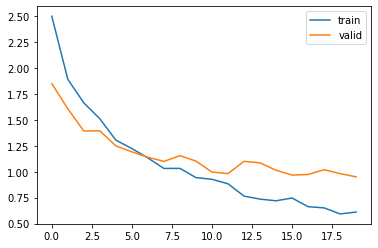

In [11]:
# plot learning curves
from matplotlib import pyplot as plt
plt.plot(train_errs, label="train")
plt.plot(valid_errs, label="valid")
plt.legend()
plt.show()

### Task 5: Accuracy

In order to get an idea of how well this transfer learning worked,
we can evaluate the accuracy on the CIFAR 10 test data.

 > Compute and output the accuracy on the training, validation and test data.

In [12]:
@torch.no_grad()
def accuracy(logits, targets):
    """
    Compute the accuracy for given logits and targets.
    
    Parameters
    ----------
    logits : (N, K) torch.Tensor
        A mini-batch of logit vectors from the network.
    targets : (N, ) torch.Tensor
        A mini_batch of target scalars representing the labels.
        
    Returns
    -------
    acc : () torch.Tensor
        The accuracy over the mini-batch of samples.
    """
    value,ind_pred = torch.max(logits.data,1)
    return (ind_pred == targets).sum().item()/len(targets)




cifar10_test = torchvision.datasets.CIFAR10("~/.pytorch", transform = normalise, download = True,train = False)
samples_test = DataLoader(cifar10_test, batch_size=32,num_workers = 2,pin_memory=True,shuffle = True)


Files already downloaded and verified


In [13]:
test_acc = []
for i, (x,y) in enumerate(samples_test):
    x = x.to(device)
    y = y.to(device)
    pred = network.forward(x)
    res = accuracy(pred,y)
    test_acc.append(res)
    
sum(test_acc)/len(test_acc)

0.6642372204472844

## Skip-connections

One of the most popular modern network architectures for vision is the residual network.
The main feature of this architecture is the so-called skip-connection,
which allows to combine the activations with the original inputs in each layer.
Since these skip-connections open up a gradient highway,
they make it possible to train much deeper networks than is possible without the skip-connections.

Mathematically, the simplest form of a skip connection can be written as
$$\boldsymbol{s} = \boldsymbol{x} + f(\boldsymbol{x}).$$
In order for this to work, the dimensions of $\boldsymbol{x}$ and $f(\boldsymbol{x})$ must line up.
This means that in this formulation, only square layers,
i.e. layers with the same number of inputs and outputs, are possible.

In order to use a skip-connection on layers that reduce the dimensionality,
a linear transform on $\boldsymbol{x}$ can be inserted in the equation.
Since also other operations are possible, on both inputs and (pre-)activations, 
we can generalise the skip-connection formula to
$$\boldsymbol{s} = \boldsymbol{C} \cdot \boldsymbol{x} + \boldsymbol{T} \cdot f(\boldsymbol{x}),$$
where $\boldsymbol{C}$ and $\boldsymbol{T}$ are linear transformations (a.k.a. matrices).

### Task 6: Highway Networks

Given the general skip-connection formula above,
residual networks can be thought of as a special case of highway networks.
The layers in a highway network use the following expression to build the gradient highway:
$$\boldsymbol{a} = c(\boldsymbol{x}) \odot \boldsymbol{x} + t(\boldsymbol{x}) \odot f(\boldsymbol{x}),$$
where $f$ is the regular transform that computes activations from the inputs
and $c$ and $t$ are gates, i.e. layers that have activations in $[0, 1]$ (cf. LSTMs). 
The gates control how much of the inputs, resp. outputs is to be used.
Especially interesting is the case where $c(\boldsymbol{x}) = 1 - t(\boldsymbol{x})$, 
since this forces each neuron in the model to *choose* between inputs and activations and requires less weights.

 > Implement the `HighwayLayer` class to represent a layer in a highway network.
 > Use fully connected layers with reasonable activation functions for $f$, $t$ and $c$.
 > Make sure that it is possible to construct non-square layers and to use all keywordarguments.

In [14]:
class HighwayLayer(nn.Module):
    """ Fully connected layer in a highway network. """
    
    def __init__(self, in_features: int, out_features: int,
                 carry: bool = False, act:callable = torch.tanh):
        """
        Parameters
        ----------
        in_features : int
            Number of input dimensions.
        out_features : int
            Number of output dimensions.
        carry : bool
            Whether or not to use a separate carry gate.
        act : callable
            Activation function to use.
        """
        super(HighwayLayer,self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        
        self.linear_layer_f = nn.Linear(in_features,out_features)
        self.linear_layer_c = nn.Linear(in_features,out_features)
        self.linear_layer_t =  nn.Linear(in_features,out_features)
        
        self.carry = carry
        
        self.act = act
        self.act_c = torch.sigmoid
        self.act_t = torch.sigmoid
        
        #Change dimension in order to add the input
        self.identity_tens = nn.Linear(in_features,out_features,bias = False)
        if self.in_features == self.out_features:
            self.identity_tens.requires_grad = False
        
    def forward(self,x):
        if self.carry:
            f_layer = self.linear_layer_f(x)
            f_layer = self.act(f_layer)
            
            c_layer = self.linear_layer_c(x)
            c_layer = self.act_c(c_layer)
            
            t_layer = self.linear_layer_t(x)
            t_layer = self.act_t(t_layer)
            
            if self.in_features != self.out_features:
                x = self.identity_tens(x)
                
            
                    
            res = c_layer * x + t_layer * f_layer
            return res
            
        else:
            f_layer = self.linear_layer_f(x)
            f_layer = self.act(f_layer)
            
            t_layer = self.linear_layer_t(x)
            t_layer = self.act_t(t_layer)
                   
            c_layer = 1 - t_layer
            
            if self.in_features != self.out_features:
                x = self.identity_tens(x) 
            
            res = c_layer * x + t_layer * f_layer
            return res
        

In [15]:
# sanity check 1
highway = HighwayLayer(100, 100, carry = False, act = torch.tanh)
highway(torch.randn(1, 100))
sum([par.numel() for par in highway.parameters()])

40300

In [16]:
# sanity check 2
highway = HighwayLayer(1000, 10,carry = False, act = torch.tanh)
highway(torch.randn(1, 1000))
sum([par.numel() for par in highway.parameters()])

40030